# Download and Import Library

In [1]:
!pip install -q seaborn

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.17.1


# Load Dataset

**Describe Dataset**
---
---
- Bộ dữ liệu là chuẩn đoán khối u xem khối u là `ác tính` hay `lành tính` dựa trên các thông số đã cho.
---

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']

for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

In [4]:
dataset = pd.read_csv(url, names=column_names)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave_poinits_mean       569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_ste                 569 non-null    float64
 13  texture_ste                569 non-null    float64

In [6]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_poinits_mean,...,radius_largest,texture_largest,perimeter_largest,area_largest,smoothness_largest,compactness_largest,concavity_largest,concave_poinits_largest,symmetry_largest,fractal_dimension_largest
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Preprocess Data

**Split Data**
---

---
- Chia dữ liệu thành tập `Train` và tập `Test` theo tỉ lệ 3 : 2.
- *Drop* cột `id` để đơn giản hóa dữ liệu.
---

In [7]:
train_dataset = dataset.sample(frac=0.75, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
# The `id` column can be dropped since each row is unique
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

**Preprocess Data**
---

---
- Bộ dữ liệu chứa `mean`, `standard error` và `largest values` cho mỗi 10 số đo khối u được thu thập trên một mẫu.
- `diagnosis`: Cột biểu thị chuẩn đoán khối u ác tính nếu `M` và chuẩn đoán khối u lành tính nếu `B`. Đây là nhãn của bài toán và phải chuyển dữ liệu về dạng *nhị phân*.
- Bộ dữ liệu nên chuyển về dạng `tensor` để phù hợp với mô hình.
- Sử dụng `seaborn.pairplot` để trực quan hóa dữ liệu.
    * *Lưu ý* : Kiểm tra số liệu thống kê tổng thể. Mỗi *Tính năng* (feature) bao gồm một phạm vi giá trị khác nhau.
---

In [9]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

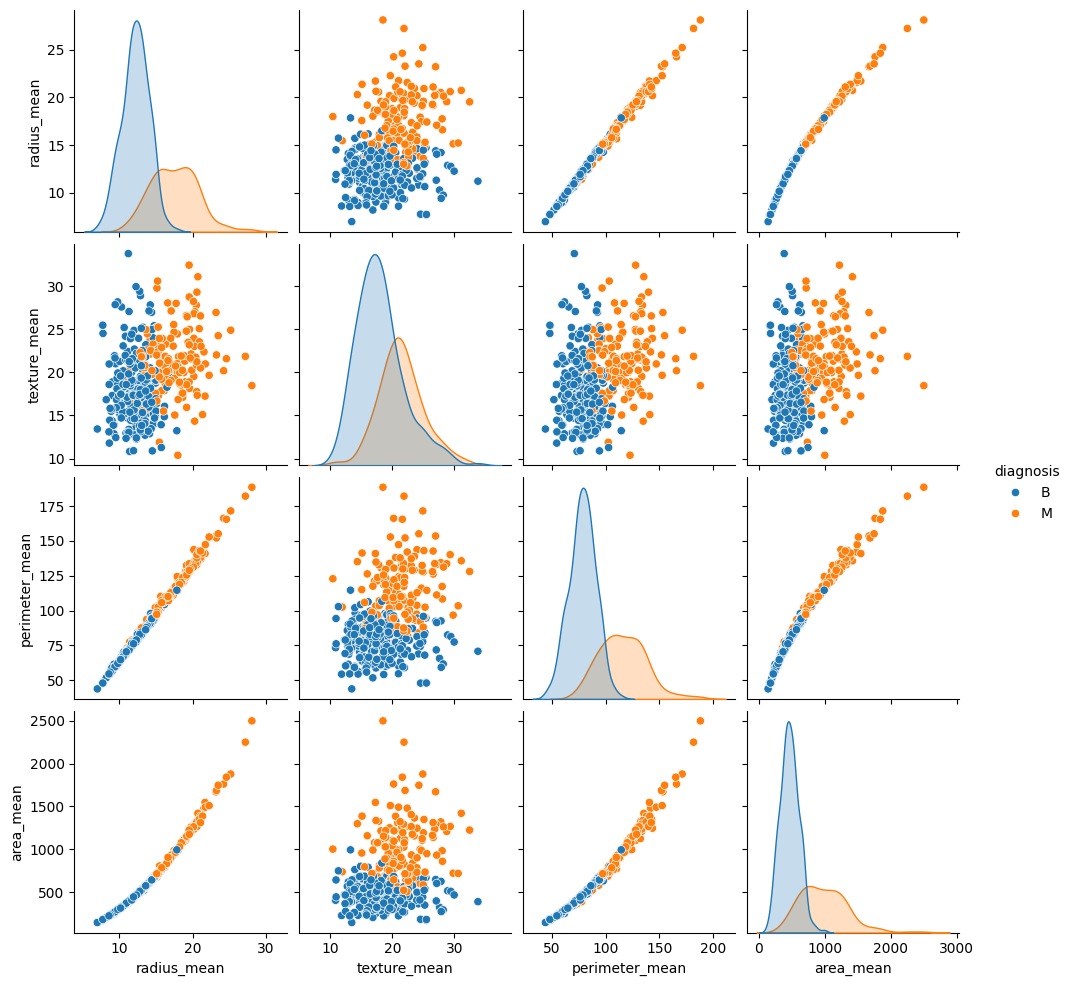

In [10]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');

In [11]:
train_dataset.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
id,427.0,2.756014e+07,1.162735e+08,8670.00000,865427.500000,905539.00000,8.810829e+06,9.113205e+08
radius_mean,427.0,1.414331e+01,3.528717e+00,6.98100,11.695000,13.43000,1.594000e+01,2.811000e+01
texture_mean,427.0,1.924468e+01,4.113131e+00,10.38000,16.330000,18.84000,2.168000e+01,3.381000e+01
perimeter_mean,427.0,9.206759e+01,2.431431e+01,43.79000,75.235000,86.87000,1.060000e+02,1.885000e+02
area_mean,427.0,6.563190e+02,3.489106e+02,143.50000,420.050000,553.50000,7.908500e+02,2.499000e+03
smoothness_mean,427.0,9.633618e-02,1.436820e-02,0.05263,0.085850,0.09566,1.050000e-01,1.634000e-01
compactness_mean,427.0,1.036597e-01,5.351893e-02,0.02344,0.063515,0.09182,1.296500e-01,3.454000e-01
concavity_mean,427.0,8.833008e-02,7.965884e-02,0.00000,0.029570,0.05999,1.297500e-01,4.268000e-01
concave_poinits_mean,427.0,4.872688e-02,3.853594e-02,0.00000,0.019650,0.03390,7.409500e-02,2.012000e-01
symmetry_mean,427.0,1.804597e-01,2.637837e-02,0.12030,0.161700,0.17840,1.947000e-01,2.906000e-01


**Normalization Data**
---

---
- Quá trình chuẩn hóa dữ liệu sao cho mỗi *feature* không có giá trị trung bình và phương sai đơn vị.
---

In [12]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

# Logistic Regression

**Fundamentals**
---

---
**Sigmoid Function**
- `Linear Regression` cho đầu ra *Không giới hạn*. Trong khi đó `Logistic Regression` (Hồi quy Logistic) cho đầu ra là một khoảng `(0, 1)`.
- Bằng cách ánh xạ các đầu ra liên tục của `Linear Regression` thành xác suất, qua đó thay đổi đầu ra `(inf, inf) -> (0, 1)`. Phép biến đổi này cũng đối xứng để việc đảo dấu của đầu ra tuyến tính dẫn đến nghịch đảo của xác suất ban đầu.
- Công thức toán học cơ bản và thông dụng là hàm `sigmoid`.
---
**Log Loss Function**
- Hàm mất mát `Loss Function` nhị phân entropy là hàm lý tưởng cho bài toán phân loại nhị phân hồi quy logistic.
- `Log Loss` định lượng sự giống nhau giữa xác suất dự đoán và giá trị thực của ví dụ.
---
**Quy tắc cập nhật Gradient Decent**
- Bằng cách lấy đạo hàm của `Loss Function` với đối tượng cần cập nhật, ta có đối tượng mới tối ưu cho mô hình Logistic Regression. Đây là cách mô hình *học* từ dữ liệu.
- Sau mỗi bước cập nhật, các tham số được cải thiện, mô hình Logistic Regression học cách phân loại tốt hơn.
---

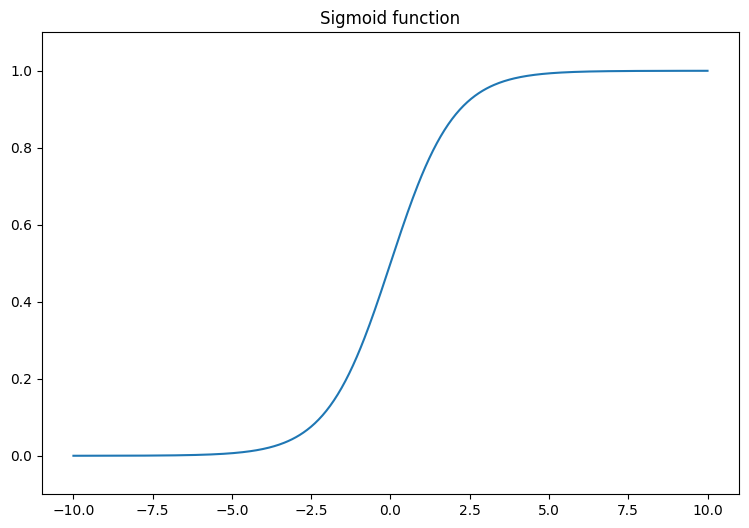

In [13]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In [14]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

**Build Model**
---

In [15]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [16]:
log_reg = LogisticRegression()

In [17]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.9994984 , 0.9978607 , 0.2962006 , 0.01979047, 0.33149227],
      dtype=float32)

---
- Viết hàm `predict`, `accuracy` để tính độ chính xác và dự đoán các `sample`.
---

In [19]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

**Train Model**
---

---
- Sử dụng mini-batch để huấn luyện mô hình.
- `mini-batch`: tính bằng cách chia tập huấn luyện cho batch, và huấn luyện trên đó. `mini-batch` càng lớn độ ổn định cao nhưng huấn luyện lâu và ngược lại.
- `steps`: mỗi `mini-batch` được hoàn thành là 1 step.
- `epoch`: hoàn thành tất cả `mini-batch` là 1 epoch.
---

In [18]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [20]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.661
Epoch: 20, Training log loss: 0.418
Epoch: 40, Training log loss: 0.269
Epoch: 60, Training log loss: 0.178
Epoch: 80, Training log loss: 0.137
Epoch: 100, Training log loss: 0.116
Epoch: 120, Training log loss: 0.106
Epoch: 140, Training log loss: 0.096
Epoch: 160, Training log loss: 0.094
Epoch: 180, Training log loss: 0.089


# Evaluation

**Perform Evaluation**
---

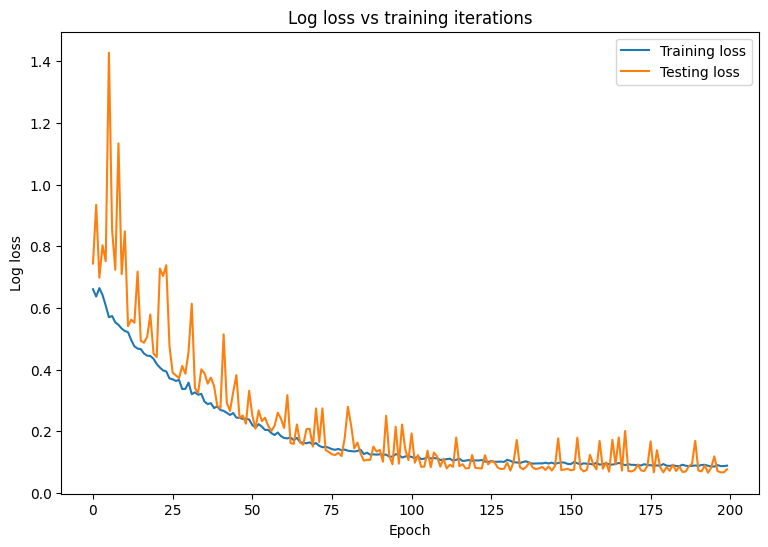

In [21]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

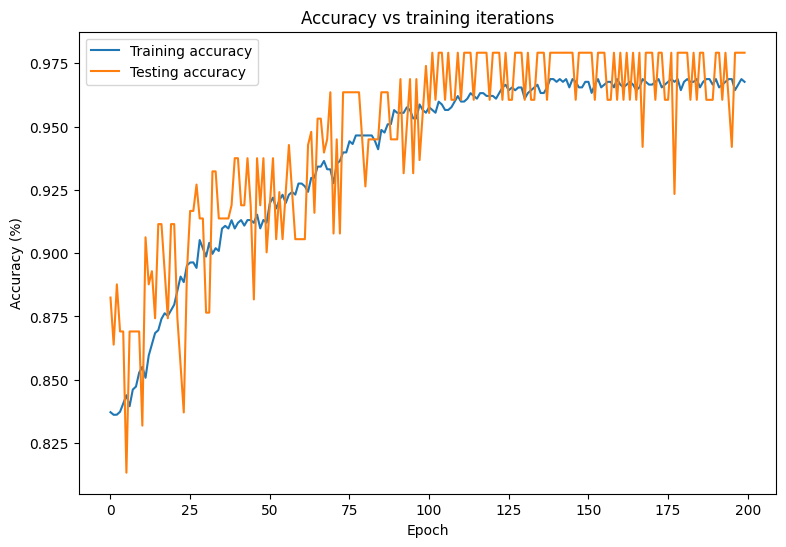

In [22]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [23]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training log loss: 0.089
Final testing log Loss: 0.077
Final training accuracy: 0.968
Final testing accuracy: 0.979


In [24]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

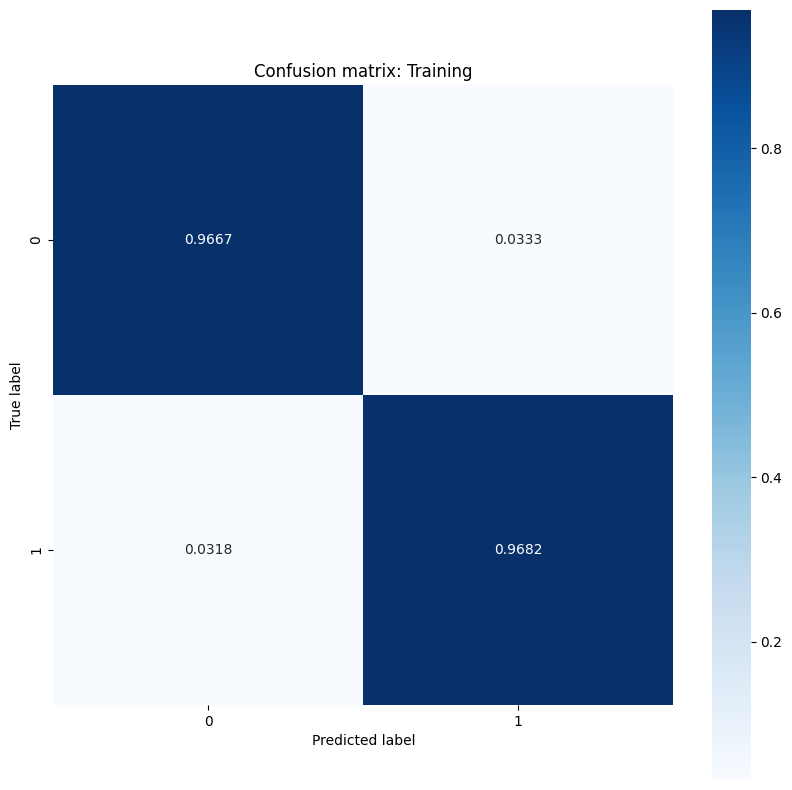

In [25]:
show_confusion_matrix(y_train, train_classes, 'Training')

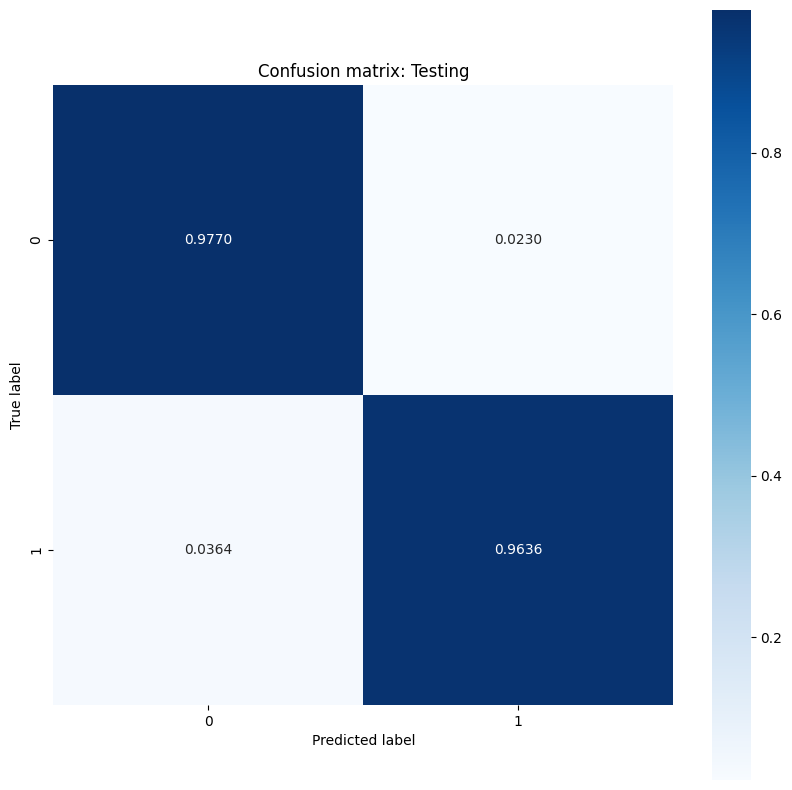

In [26]:
show_confusion_matrix(y_test, test_classes, 'Testing')

---
Đánh giá:
- Mô hình huấn luyện cho kết quả tốt.
- Các thông số cho ra đúng mong đợi.
- Độ chính xác cao.
- Huấn luyện nhanh.
- Có thể ứng dụng vào thực tế.
---

# Save Model

In [ ]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

In [ ]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

In [ ]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

In [ ]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()